In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

train_dir = os.getcwd() + "/../train/"
train_files = os.listdir(train_dir)

bad_imgs_path = os.path.join(os.getcwd(), "badimgs.txt")
with open(bad_imgs_path, "r") as f:
    bad_imgs = {line.strip() for line in f if line.strip()}

# UTILS

def get_rand_img_path():
    return train_dir + random.choice(train_files)

def get_img(label):
    path = os.path.join(train_dir,f"{label}-0.png")
    img = cv2.imread(path)
    return img

def get_label(img_path):
    filename = os.path.basename(img_path)
    label = filename.split('-')[0]
    return label

def get_rand_img():
    path = get_rand_img_path()
    label = get_label(path)
    img = cv2.imread(path)
    return img, label

def show_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    
    # Remove lines
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    
    return removed

In [2]:
def log_gabor_filter_bank(shape, n_orient=8, n_scale=4, min_wavelength=3, mult=2.1, sigma_onf=0.55):
    """Generate a bank of Log-Gabor filters."""
    rows, cols = shape
    y, x = np.mgrid[-0.5:0.5:(rows*1j), -0.5:0.5:(cols*1j)]
    radius = np.sqrt(x**2 + y**2)
    radius[rows//2, cols//2] = 1  # avoid log(0)
    theta = np.arctan2(-y, x)

    filters = []
    for s in range(n_scale):
        wavelength = min_wavelength * (mult ** s)
        fo = 1.0 / wavelength
        log_gabor_radial = np.exp((-(np.log(radius / fo)) ** 2) / (2 * (np.log(sigma_onf)) ** 2))
        log_gabor_radial[radius < 0.001] = 0  # remove DC

        for o in range(n_orient):
            angl = o * np.pi / n_orient
            ds = np.sin(theta) * np.cos(angl) - np.cos(theta) * np.sin(angl)
            dc = np.cos(theta) * np.cos(angl) + np.sin(theta) * np.sin(angl)
            dtheta = np.abs(np.arctan2(ds, dc))
            spread = np.exp((-dtheta ** 2) / (2 * (np.pi / n_orient * 0.55) ** 2))

            filt = log_gabor_radial * spread
            filters.append(filt)
    return filters

def apply_log_gabor(img_gray, n_orient=8, n_scale=4):
    """Apply a log-gabor filter bank to a grayscale image."""
    # FFT
    img_f = np.fft.fft2(img_gray)
    filters = log_gabor_filter_bank(img_gray.shape, n_orient, n_scale)
    
    responses = []
    for filt in filters:
        result = np.fft.ifft2(img_f * np.fft.fftshift(filt))
        responses.append(np.abs(result))
    
    combined = np.max(np.stack(responses, axis=-1), axis=-1)
    combined = cv2.normalize(combined, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return combined

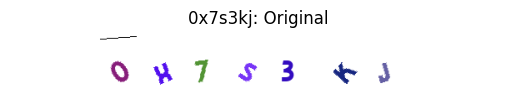

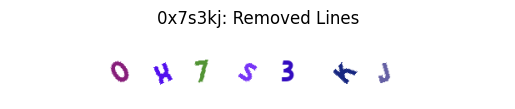

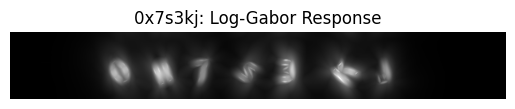

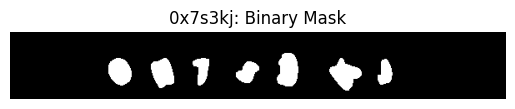

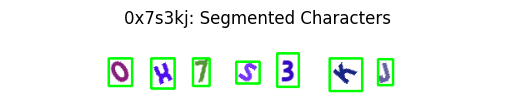

In [5]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Removed Lines")

gray = cv2.cvtColor(img_clean, cv2.COLOR_BGR2GRAY)
seg_map = apply_log_gabor(gray, n_orient=8, n_scale=4)

show_img(seg_map, title=f"{label}: Log-Gabor Response")

# 1. Normalize and threshold
norm = cv2.normalize(seg_map, None, 0, 255, cv2.NORM_MINMAX)
_, binary = cv2.threshold(norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 2. Morphological cleanup
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

show_img(binary, title=f"{label}: Binary Mask")

# 3. Connected components (each ≈ one character)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# 4. Filter components by size to remove noise
char_regions = []
h, w = binary.shape
for i in range(1, num_labels):  # skip background
    x, y, bw, bh, area = stats[i]
    if area > 50 and bh > h * 0.3:  # tune thresholds to your dataset
        char_regions.append((x, y, bw, bh))

# 5. Sort characters left-right
char_regions.sort(key=lambda r: r[0])

# 6. Visualize results
img_vis = img_clean.copy()
for (x, y, bw, bh) in char_regions:
    cv2.rectangle(img_vis, (x, y), (x+bw, y+bh), (0, 255, 0), 2)

show_img(img_vis, title=f"{label}: Segmented Characters")

# 7. Optional: extract individual masks
chars = [binary[y:y+bh, x:x+bw] for (x, y, bw, bh) in char_regions]

In [3]:
def log_gabor_pipeline(img, output_size=(64, 64)):
    # 1. Remove Lines
    img_clean = remove_lines(img)

    # 2. Convert to Grayscale
    gray = cv2.cvtColor(img_clean, cv2.COLOR_BGR2GRAY)

    # 3. Apply log Gabor
    seg_map = apply_log_gabor(gray, n_orient=8, n_scale=4)

    # 4. Normalize and threshold
    norm = cv2.normalize(seg_map, None, 0, 255, cv2.NORM_MINMAX)
    _, binary = cv2.threshold(norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 5. Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # 6. Connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # 7. Filter components by size
    char_regions = []
    h, w = binary.shape
    for i in range(1, num_labels):  # skip background
        x, y, bw, bh, area = stats[i]
        if area > 50 and bh > h * 0.3:
            char_regions.append((x, y, bw, bh))

    # 8. Sort characters left-right
    char_regions.sort(key=lambda r: r[0])

    # 9. Mask and resize characters on the original image
    chars_masked = []
    for (x, y, bw, bh) in char_regions:
        # Create a black mask
        mask = np.zeros_like(gray)
        # Copy the character area from the original image
        mask[y:y+bh, x:x+bw] = gray[y:y+bh, x:x+bw]
        # Crop the bounding box
        char_patch = mask[y:y+bh, x:x+bw]
        # Resize to output_size
        resized_patch = cv2.resize(char_patch, output_size, interpolation=cv2.INTER_AREA)
        chars_masked.append(resized_patch)

    return chars_masked

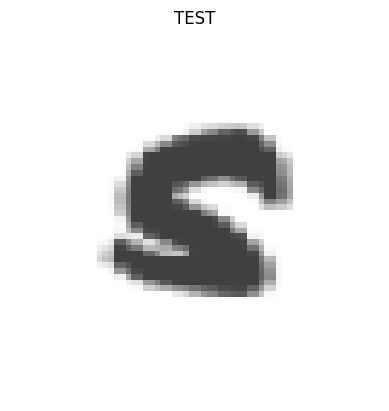

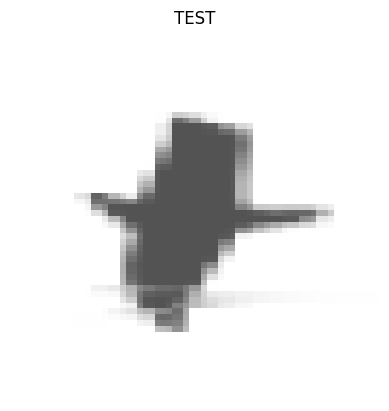

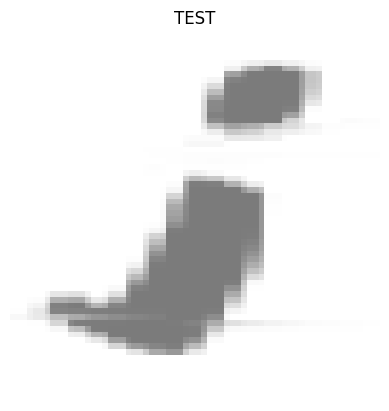

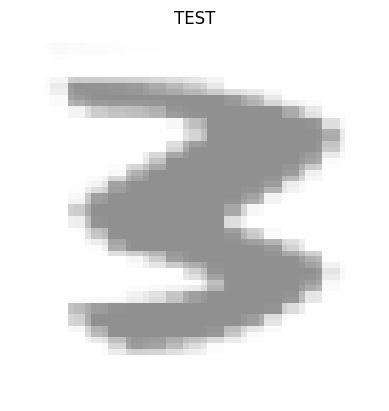

4


In [12]:
img, label = get_rand_img()
chars = log_gabor_pipeline(img)

for c in chars:
    show_img(c, "TEST")

print(len(chars))

In [4]:
# Normal Scale
results = [0, 0]

for f in train_files:
    img = cv2.imread(train_dir + f)
    chars = log_gabor_pipeline(img)
    if len(chars) == len(f[:-6]):
        results[0] += 1
    else:
        results[1] += 1

print(results, results[0]/sum(results))

[1337, 6673] 0.166916354556804
